<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Modelling_Traffic_in_Urban_Areas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras

In [94]:
controller_data = pd.read_csv('pems_output.csv')

In [95]:
controller_data["5 Minutes"] = pd.to_datetime(controller_data["5 Minutes"])
controller_data.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow = controller_data[['Flow (Veh/5 Minutes)']]

print(time_flow)

                     Flow (Veh/5 Minutes)
5 Minutes                                
2024-01-21 00:00:00                   249
2024-01-21 00:05:00                   265
2024-01-21 00:10:00                   213
2024-01-21 00:15:00                   252
2024-01-21 00:20:00                   252
...                                   ...
2024-01-27 06:35:00                   185
2024-01-27 06:40:00                   182
2024-01-27 06:45:00                   213
2024-01-27 06:50:00                   185
2024-01-27 06:55:00                   190

[1812 rows x 1 columns]


In [96]:
# Normalise
scaler = MinMaxScaler()
flow_normalised = scaler.fit_transform(time_flow)

In [97]:
# Train and validation split
train = len(flow_normalised)*0.8
X_train, X_val, = flow_normalised[:int(train)], flow_normalised[int(train):]

In [106]:
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 7
X_train, y_train = create_dataset(X_train, look_back)
X_val, y_val = create_dataset(X_val, look_back)

print(X_train[:5])

# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

[[[0.57761733]
  [0.63537906]
  [0.44765343]
  [0.58844765]
  [0.58844765]
  [0.46570397]
  [0.50902527]]

 [[0.63537906]
  [0.44765343]
  [0.58844765]
  [0.58844765]
  [0.46570397]
  [0.50902527]
  [0.51624549]]

 [[0.44765343]
  [0.58844765]
  [0.58844765]
  [0.46570397]
  [0.50902527]
  [0.51624549]
  [0.433213  ]]

 [[0.58844765]
  [0.58844765]
  [0.46570397]
  [0.50902527]
  [0.51624549]
  [0.433213  ]
  [0.38267148]]

 [[0.58844765]
  [0.46570397]
  [0.50902527]
  [0.51624549]
  [0.433213  ]
  [0.38267148]
  [0.39350181]]]


In [99]:
input_layer = keras.layers.Input(shape=(look_back, 1))
encoded = keras.layers.LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(look_back, activation='linear')(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 7, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 7, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,879 (124.53 KB)

 Trainable params: 31,879 (124.53 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=20, validation_data=[X_val, X_val])

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.2669 - val_loss: 0.0168
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

In [101]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_val = encoder.predict(X_val)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [102]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(1, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_val, y_val))


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5722 - val_loss: 0.2701
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2688 - val_loss: 0.2154
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1992 - val_loss: 0.1244
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1053 - val_loss: 0.0354
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0272 - val_loss: 0.0153
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_loss: 0.0130
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - val_loss: 0.0083
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0082 - val_loss: 0.0065
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0064


In [103]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_val)

# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


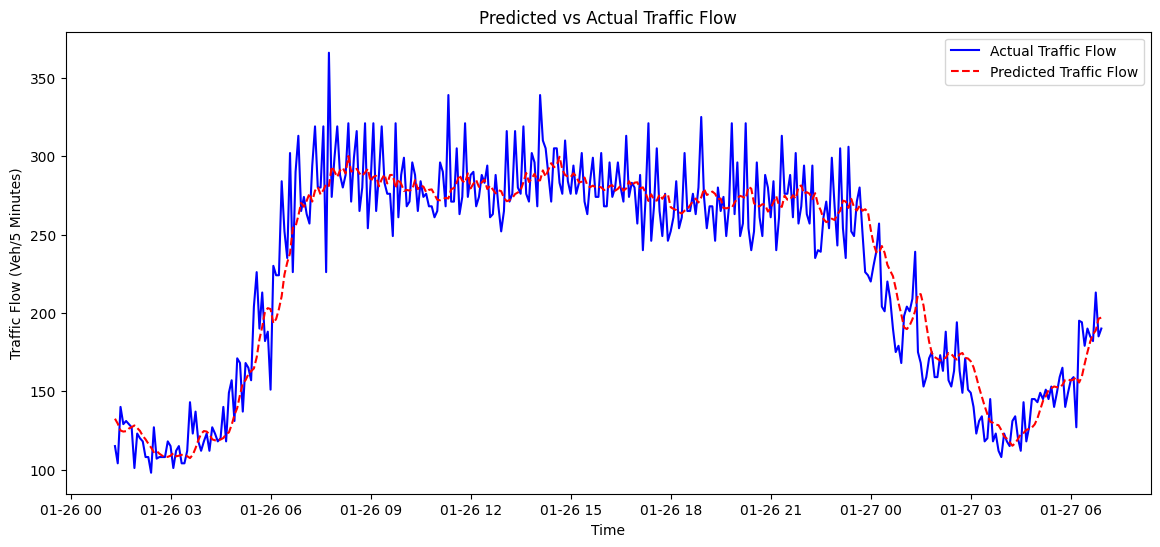

In [104]:
# timestamps from validation set.
timestamps = time_flow.index[-len(y_val):]

import matplotlib.pyplot as plt

# Rescale the predicted values and actual values to their original scale
y_test_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(timestamps, y_test_rescaled, label='Actual Traffic Flow', color='blue')
plt.plot(timestamps, y_pred_rescaled, label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()

